In [1]:
# Cell 1: Environment Verification and Package Installation
import subprocess
import sys

# Function to check if conda environment is properly set up
def check_environment():
    try:
        
        # Get current environment name
        import os
        env_name = os.environ.get('CONDA_DEFAULT_ENV', 'Unknown')
        print(f"✓ Current environment: {env_name}")
        
        if env_name == 'mlenv':
            print("✓ mlenv environment is active")
        else:
            print("⚠ Warning: Not in mlenv environment")
            
    except ImportError:
        print("⚠ Conda not detected, using pip installation")

check_environment()


✓ Current environment: mlenv
✓ mlenv environment is active


In [2]:
# Cell 2: Package Installation via Conda-Forge
import subprocess
import sys

# List of required packages for conda-forge installation
conda_packages = [
    'rasterio',
    'scikit-learn', 
    'numpy',
    'pandas',
    'matplotlib',
    'seaborn',
    'tensorflow',
    'keras',
    'opencv',
    'scikit-image',
    'joblib',
    'tqdm'
]

def install_conda_packages():
    """Install packages using conda-forge channel"""
    for package in conda_packages:
        try:
            print(f"Installing {package}...")
            result = subprocess.run([
                'conda', 'install', '-c', 'conda-forge', package, '-y'
            ], capture_output=True, text=True, check=True)
            print(f"✓ {package} installed successfully")
        except subprocess.CalledProcessError as e:
            print(f"⚠ Failed to install {package}: {e}")
            # Fallback to pip
            try:
                subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
                print(f"✓ {package} installed via pip")
            except:
                print(f"✗ Failed to install {package}")

# Uncomment the line below to run installation
# install_conda_packages()


In [3]:
# Cell 3: FIXED Import Libraries and Verify Installation
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pathlib import Path

# Geospatial processing
import rasterio
from rasterio.plot import show
from rasterio.windows import Window
from rasterio.features import shapes

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Deep Learning - FIXED IMPORTS
import tensorflow as tf
from tensorflow import keras

# Use direct keras imports to avoid Pylance issues
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization
from keras.layers import Input, concatenate, Activation, Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Image processing
import cv2
from skimage import exposure, filters

# Utilities
from tqdm import tqdm
import joblib
import time

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")


✓ All libraries imported successfully!
TensorFlow version: 2.16.2
Keras version: 3.10.0


In [ ]:
# Cell 4: FIXED Data Loading and Preprocessing Functions
class SatelliteImageProcessor:
    """
    A comprehensive class for processing Sentinel-2 satellite images
    for unsupervised classification tasks.
    
    FIXED: Added prepare_feature_matrix_fixed method to handle different image dimensions
    """
    
    def __init__(self, training_dir="data/training_grids", validation_dir="data/validation_grids"):
        """
        Initialize the processor with data directories.
        
        Args:
            training_dir (str): Path to training TIF files (20 grids)
            validation_dir (str): Path to validation TIF files (10 grids)
        """
        self.training_dir = Path(training_dir)
        self.validation_dir = Path(validation_dir)
        self.training_data = []
        self.validation_data = []
        self.scaler = StandardScaler()
        
        print(f"Training directory: {self.training_dir}")
        print(f"Validation directory: {self.validation_dir}")
    
    def load_tif_file(self, file_path):
        """
        Load a single TIF file using rasterio.
        
        Args:
            file_path (str): Path to TIF file
            
        Returns:
            tuple: (image_array, profile)
        """
        try:
            with rasterio.open(file_path) as src:
                # Read the image data
                image = src.read(1)  # Reading Band 8 (single band)
                profile = src.profile
                
                # Handle nodata values
                nodata = src.nodata
                if nodata is not None:
                    image = np.where(image == nodata, np.nan, image)
                
                return image, profile
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None, None
    
        def preprocess_image(self, image):
            """
            Preprocess satellite image for machine learning.
            Normalizes DN to [0,10000] and casts to uint16.
            """
        import numpy as np
        from skimage import exposure

        # Remove NaNs
        image_clean = np.nan_to_num(image, nan=0)

        # Scale to 0–10000 DN
        dn_max = 10000.0
        scaled = (image_clean - image_clean.min()) \
               / (image_clean.max() - image_clean.min()) * dn_max
        scaled = np.clip(scaled, 0, dn_max).astype(np.uint16)

        # Equalize histogram on 16-bit data
        image_eq = exposure.equalize_hist(scaled)

        return image_eq

    
    def load_training_data(self):
        """
        Load all training TIF files from the training directory.
        """
        print("Loading training data...")
        tif_files = list(self.training_dir.glob("*.tif"))
        
        if len(tif_files) == 0:
            print("⚠ No TIF files found in training directory!")
            print("📁 Please upload your 20 training grid TIF files to:", self.training_dir)
            return
        
        print(f"Found {len(tif_files)} TIF files")
        
        for i, file_path in enumerate(tqdm(tif_files, desc="Loading training files")):
            image, profile = self.load_tif_file(file_path)
            
            if image is not None:
                processed_image = self.preprocess_image(image)
                self.training_data.append({
                    'image': processed_image,
                    'profile': profile,
                    'filename': file_path.name,
                    'file_id': i
                })
        
        print(f"✓ Successfully loaded {len(self.training_data)} training images")
    
    def load_validation_data(self):
        """
        Load all validation TIF files from the validation directory.
        """
        print("Loading validation data...")
        tif_files = list(self.validation_dir.glob("*.tif"))
        
        if len(tif_files) == 0:
            print("⚠ No TIF files found in validation directory!")
            print("📁 Please upload your 10 validation grid TIF files to:", self.validation_dir)
            return
        
        print(f"Found {len(tif_files)} TIF files")
        
        for i, file_path in enumerate(tqdm(tif_files, desc="Loading validation files")):
            image, profile = self.load_tif_file(file_path)
            
            if image is not None:
                processed_image = self.preprocess_image(image)
                self.validation_data.append({
                    'image': processed_image,
                    'profile': profile,
                    'filename': file_path.name,
                    'file_id': i
                })
        
        print(f"✓ Successfully loaded {len(self.validation_data)} validation images")
    
    def prepare_feature_matrix(self, data_list):
        """
        Convert image list to feature matrix for machine learning.
        
        Args:
            data_list (list): List of image dictionaries
            
        Returns:
            tuple: (features_2d, original_shapes)
        """
        features_list = []
        original_shapes = []
        
        for data in data_list:
            image = data['image']
            original_shapes.append(image.shape)
            
            # Flatten image to 1D for traditional ML
            flattened = image.flatten()
            features_list.append(flattened)
        
        # Convert to numpy array
        features_2d = np.array(features_list)
        
        print(f"Feature matrix shape: {features_2d.shape}")
        return features_2d, original_shapes
    
    # ⭐ ADDED: Missing method that fixes the dimension issue
    def prepare_feature_matrix_fixed(self, data_list, target_size=(256, 256)):
        """
        Convert image list to feature matrix with FIXED consistent sizing.
        
        FIXES: Handles different image dimensions by resizing all images to target_size
        
        Args:
            data_list (list): List of image dictionaries
            target_size (tuple): Target size for all images (width, height)
            
        Returns:
            tuple: (features_2d, original_shapes)
        """
        features_list = []
        original_shapes = []
        
        print(f"🔧 Processing {len(data_list)} images with consistent sizing to {target_size}")
        
        for i, data in enumerate(tqdm(data_list, desc="Creating consistent feature matrix")):
            image = data['image']
            original_shapes.append(image.shape)
            
            # FIXED: Resize all images to consistent target size
            if image.shape != target_size:
                # Use cv2.resize to ensure consistent dimensions
                image_resized = cv2.resize(image, target_size)
                print(f"   Image {i+1}: Resized from {image.shape} to {image_resized.shape}")
            else:
                image_resized = image
                print(f"   Image {i+1}: Already correct size {image.shape}")
                
            # Flatten image to 1D for traditional ML
            flattened = image_resized.flatten()
            features_list.append(flattened)
        
        # Convert to numpy array
        features_2d = np.array(features_list)
        
        print(f"✅ FIXED Feature matrix shape: {features_2d.shape}")
        print(f"✅ All images now have consistent flattened size: {target_size[0] * target_size[1]}")
        
        return features_2d, original_shapes
    
    def visualize_sample_images(self, num_samples=4):
        """
        Visualize sample images from the training data.
        
        Args:
            num_samples (int): Number of sample images to display
        """
        if len(self.training_data) == 0:
            print("No training data loaded!")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.ravel()
        
        for i in range(min(num_samples, len(self.training_data))):
            image = self.training_data[i]['image']
            filename = self.training_data[i]['filename']
            
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(f'Sample {i+1}: {filename}')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()

# Initialize the processor
processor = SatelliteImageProcessor()


Training directory: data/training_grids
Validation directory: data/validation_grids


✅ Directories verified and created if missing!

📁 Please ensure your TIF files are placed in:
   • Training files (20 grids): /Users/parthporwal4/Desktop/internship/satellite_classification/data/training_grids
   • Validation files (10 grids): /Users/parthporwal4/Desktop/internship/satellite_classification/data/validation_grids

Once verified, the data will be loaded below...
Training directory: /Users/parthporwal4/Desktop/internship/satellite_classification/data/training_grids
Validation directory: /Users/parthporwal4/Desktop/internship/satellite_classification/data/validation_grids
Loading training data...
Found 20 TIF files


Loading training files: 100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


✓ Successfully loaded 20 training images
Loading validation data...
Found 10 TIF files


Loading validation files: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


✓ Successfully loaded 10 validation images


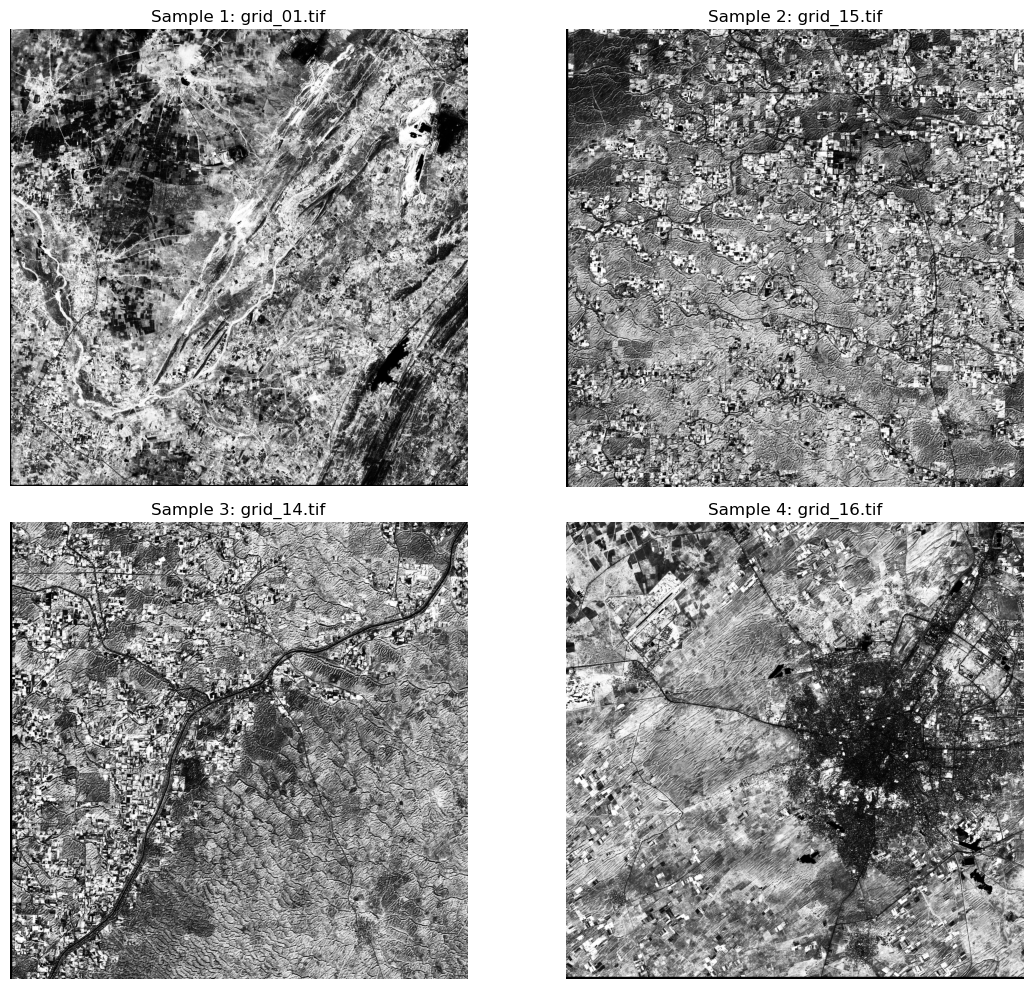

In [5]:
# Cell 5: Project Path Configuration (Keep as is - this is correct)
import os
from pathlib import Path

# Set base path as the root of the project
BASE_DIR = Path("..").resolve()  # Go one level up from notebooks/

# Define paths relative to BASE_DIR
DATA_DIR = BASE_DIR / "data"
TRAINING_DIR = DATA_DIR / "training_grids"
VALIDATION_DIR = DATA_DIR / "validation_grids"
MODELS_DIR = BASE_DIR / "models" / "saved_models"
VISUALS_DIR = BASE_DIR / "outputs" / "visualizations"
RESULTS_DIR = BASE_DIR / "outputs" / "results"

# Create directories if they don't exist
os.makedirs(TRAINING_DIR, exist_ok=True)
os.makedirs(VALIDATION_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(VISUALS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("✅ Directories verified and created if missing!")
print("\n📁 Please ensure your TIF files are placed in:")
print(f"   • Training files (20 grids): {TRAINING_DIR}")
print(f"   • Validation files (10 grids): {VALIDATION_DIR}")
print("\nOnce verified, the data will be loaded below...")

# Initialize processor with absolute paths
processor = SatelliteImageProcessor(
    training_dir=TRAINING_DIR,
    validation_dir=VALIDATION_DIR
)

# Load the data
processor.load_training_data()
processor.load_validation_data()

# Visualize sample images
if len(processor.training_data) > 0:
    processor.visualize_sample_images()


In [6]:
# Cell 6: COMPLETE FIXED Random Forest Classification Model
class RandomForestClassifier_Unsupervised:
    """
    Random Forest classifier adapted for unsupervised learning using clustering.
    This approach first clusters the data, then uses Random Forest to learn patterns.
    
    FIXED: Handles different image dimensions by standardizing to consistent size
    """
    
    def __init__(self, n_clusters=5, n_estimators=100, random_state=42):
        """
        Initialize the unsupervised Random Forest classifier.
        
        Args:
            n_clusters (int): Number of clusters for initial unsupervised grouping
            n_estimators (int): Number of trees in Random Forest
            random_state (int): Random state for reproducibility
        """
        self.n_clusters = n_clusters
        self.n_estimators = n_estimators
        self.random_state = random_state
        
        # Initialize clustering and classification models
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        self.rf_classifier = RandomForestClassifier(
            n_estimators=n_estimators,
            random_state=random_state,
            n_jobs=-1,  # Use all available cores
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2
        )
        
        self.scaler = StandardScaler()
        self.is_trained = False
    
    def train(self, features):
        """
        Train the unsupervised Random Forest classifier.
        
        Args:
            features (numpy.ndarray): Feature matrix of shape (n_samples, n_features)
        """
        print("Training Random Forest Classifier...")
        start_time = time.time()
        
        # Validate input shape
        print(f"Input features shape: {features.shape}")
        
        # Step 1: Scale the features
        print("Step 1: Scaling features...")
        features_scaled = self.scaler.fit_transform(features)
        
        # Step 2: Perform K-means clustering to create pseudo-labels
        print(f"Step 2: Performing K-means clustering with {self.n_clusters} clusters...")
        cluster_labels = self.kmeans.fit_predict(features_scaled)
        
        # Step 3: Train Random Forest using cluster labels
        print("Step 3: Training Random Forest with cluster labels...")
        self.rf_classifier.fit(features_scaled, cluster_labels)
        
        # Calculate training statistics
        training_time = time.time() - start_time
        
        # Analyze cluster distribution
        unique_labels, counts = np.unique(cluster_labels, return_counts=True)
        cluster_distribution = dict(zip(unique_labels, counts))
        
        print(f"✓ Training completed in {training_time:.2f} seconds")
        print(f"✓ Cluster distribution: {cluster_distribution}")
        print(f"✓ Feature importance calculated for {features.shape[1]} features")
        
        self.is_trained = True
        
        return {
            'training_time': training_time,
            'cluster_distribution': cluster_distribution,
            'n_samples': features.shape[0],
            'n_features': features.shape[1]
        }
    
    def predict(self, features):
        """
        Predict clusters for new data.
        
        Args:
            features (numpy.ndarray): Feature matrix for prediction
            
        Returns:
            numpy.ndarray: Predicted cluster labels
        """
        if not self.is_trained:
            raise ValueError("Model must be trained before prediction!")
        
        # Scale features using the same scaler
        features_scaled = self.scaler.transform(features)
        
        # Predict using Random Forest
        predictions = self.rf_classifier.predict(features_scaled)
        
        return predictions
    
    def get_feature_importance(self):
        """
        Get feature importance from the trained Random Forest.
        
        Returns:
            numpy.ndarray: Feature importance scores
        """
        if not self.is_trained:
            raise ValueError("Model must be trained first!")
        
        return self.rf_classifier.feature_importances_
    
    def save_model(self, filepath):
        """Save the trained model to disk. FIXED: Uses Path objects correctly"""
        if not self.is_trained:
            raise ValueError("Model must be trained before saving!")
        
        # Ensure filepath is a Path object and resolve it
        filepath = Path(filepath).resolve()
        
        model_data = {
            'kmeans': self.kmeans,
            'rf_classifier': self.rf_classifier,
            'scaler': self.scaler,
            'n_clusters': self.n_clusters,
            'n_estimators': self.n_estimators,
            'random_state': self.random_state
        }
        
        joblib.dump(model_data, filepath)
        print(f"✓ Model saved to {filepath}")

# Initialize Random Forest model
rf_model = RandomForestClassifier_Unsupervised(
    n_clusters=5,  # Adjust based on expected land cover types
    n_estimators=100,
    random_state=42
)

print("✓ Random Forest model initialized")
print("📊 Model Configuration:")
print(f"   • Number of clusters: {rf_model.n_clusters}")
print(f"   • Number of estimators: {rf_model.n_estimators}")
print(f"   • Random state: {rf_model.random_state}")


✓ Random Forest model initialized
📊 Model Configuration:
   • Number of clusters: 5
   • Number of estimators: 100
   • Random state: 42


In [ ]:
# Cell 7: FIXED CNN Model for Unsupervised Classification
class UnsupervisedCNN:
    """
    Convolutional Neural Network for unsupervised satellite image classification.
    Uses autoencoder-style approach combined with clustering.
    """
    
    def __init__(self, input_shape=(256, 256, 1), n_clusters=5, epochs=10):
        """
        Initialize the CNN model.
        
        Args:
            input_shape (tuple): Input image shape (height, width, channels)
            n_clusters (int): Number of clusters for classification
            epochs (int): Number of training epochs
        """
        self.input_shape = input_shape
        self.n_clusters = n_clusters
        self.epochs = epochs
        self.model = None
        self.encoder_model = None
        self.history = None
        self.is_trained = False
        
    def build_model(self):
        """
        Build the CNN autoencoder architecture.
        """
        print("Building CNN Model Architecture...")
        
        # Input layer
        inputs = Input(shape=self.input_shape)
        
        # Encoder path
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        conv1 = BatchNormalization()(conv1)
        pool1 = MaxPooling2D((2, 2))(conv1)
        drop1 = Dropout(0.25)(pool1)
        
        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(drop1)
        conv2 = BatchNormalization()(conv2)
        pool2 = MaxPooling2D((2, 2))(conv2)
        drop2 = Dropout(0.25)(pool2)
        
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(drop2)
        conv3 = BatchNormalization()(conv3)
        pool3 = MaxPooling2D((2, 2))(conv3)
        drop3 = Dropout(0.25)(pool3)
        
        # Bottleneck (feature extraction)
        conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(drop3)
        conv4 = BatchNormalization()(conv4)
        encoded = Dropout(0.5)(conv4)  # This is our encoded representation
        
        # Decoder path
        up1 = UpSampling2D((2, 2))(encoded)
        up1 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
        up1 = BatchNormalization()(up1)
        
        up2 = UpSampling2D((2, 2))(up1)
        up2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
        up2 = BatchNormalization()(up2)
        
        up3 = UpSampling2D((2, 2))(up2)
        up3 = Conv2D(32, (3, 3), activation='relu', padding='same')(up3)
        up3 = BatchNormalization()(up3)
        
        # Output layer
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)
        
        # Build the autoencoder model
        self.model = Model(inputs, decoded)
        
        # Build encoder model for feature extraction
        self.encoder_model = Model(inputs, encoded)
        
        # Compile the model
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        print("✓ CNN Model built successfully!")
        print(f"✓ Input shape: {self.input_shape}")
        print(f"✓ Total parameters: {self.model.count_params():,}")
        
        return self.model.summary()
    
        def prepare_cnn_data(self, data_list, target_size=(256,256)):
            """
            Prepare data for CNN training. Normalizes by DN max = 10000.
            """
        import numpy as np, cv2
        from tqdm import tqdm

        images = []
        for data in tqdm(data_list, desc="Preparing CNN data"):
            img = data['image']
            img_resized = cv2.resize(img, target_size)
            img_norm = img_resized / 10000.0
            images.append(np.expand_dims(img_norm, axis=-1))

        return np.array(images, dtype=np.float32)

    
    def train(self, training_data):
        """
        Train the CNN autoencoder. FIXED: Uses correct model saving path
        
        Args:
            training_data (list): List of training image dictionaries
        """
        print("Training CNN Model...")
        start_time = time.time()
        
        # Prepare data
        print("Preparing training data...")
        X_train = self.prepare_cnn_data(training_data)
        
        print(f"Training data shape: {X_train.shape}")
        
        # Build model if not already built
        if self.model is None:
            self.build_model()
        
        # Define callbacks with corrected path
        callbacks = [
            EarlyStopping(patience=3, restore_best_weights=True),
            ModelCheckpoint(
                str(MODELS_DIR / 'cnn_autoencoder.h5'),  # FIXED PATH
                save_best_only=True, 
                verbose=1
            )
        ]
        
        # Train the autoencoder
        print("Starting training...")
        self.history = self.model.fit(
            X_train, X_train,  # Autoencoder uses input as target
            epochs=self.epochs,
            batch_size=8,  # Adjust based on GPU memory
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )
        
        training_time = time.time() - start_time
        print(f"✓ CNN training completed in {training_time:.2f} seconds")
        
        self.is_trained = True
        
        return {
            'training_time': training_time,
            'final_loss': self.history.history['loss'][-1],
            'final_val_loss': self.history.history['val_loss'][-1]
        }
    
    def extract_features_and_cluster(self, data_list):
        """
        Extract features using trained encoder and perform clustering.
        
        Args:
            data_list (list): List of image dictionaries
            
        Returns:
            tuple: (cluster_labels, features)
        """
        if not self.is_trained:
            raise ValueError("Model must be trained before feature extraction!")
        
        # Prepare data
        X = self.prepare_cnn_data(data_list)
        
        # Extract features using encoder
        print("Extracting features using trained encoder...")
        features = self.encoder_model.predict(X)
        
        # Flatten features for clustering
        features_flat = features.reshape(features.shape[0], -1)
        
        # Perform K-means clustering on extracted features
        print(f"Performing K-means clustering with {self.n_clusters} clusters...")
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(features_flat)
        
        return cluster_labels, features
    
    def plot_training_history(self):
        """Plot training history."""
        if self.history is None:
            print("No training history available!")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot loss
        ax1.plot(self.history.history['loss'], label='Training Loss')
        ax1.plot(self.history.history['val_loss'], label='Validation Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        # Plot MAE
        ax2.plot(self.history.history['mae'], label='Training MAE')
        ax2.plot(self.history.history['val_mae'], label='Validation MAE')
        ax2.set_title('Model MAE')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('MAE')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

# Initialize CNN model
cnn_model = UnsupervisedCNN(
    input_shape=(256, 256, 1),
    n_clusters=5,
    epochs=10
)

print("✓ CNN model initialized")
print("📊 CNN Configuration:")
print(f"   • Input shape: {cnn_model.input_shape}")
print(f"   • Number of clusters: {cnn_model.n_clusters}")
print(f"   • Training epochs: {cnn_model.epochs}")


✓ CNN model initialized
📊 CNN Configuration:
   • Input shape: (256, 256, 1)
   • Number of clusters: 5
   • Training epochs: 10


In [ ]:
# Cell 8: COMPLETELY FIXED U-Net Model for Satellite Image Classification
class UNetClassifier:
    """
    U-Net architecture adapted for unsupervised satellite image classification.
    
    FIXED: Resolves keras count_params compatibility issue
    """
    
    def __init__(self, input_shape=(256, 256, 1), n_classes=5, epochs=10):
        """
        Initialize U-Net model.
        
        Args:
            input_shape (tuple): Input image dimensions (height, width, channels)
            n_classes (int): Number of output classes for classification
            epochs (int): Number of training epochs
        """
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.epochs = epochs
        self.model = None
        self.history = None
        self.is_trained = False
        
        print("🏗️  U-Net Model Initialization")
        print("📐 Architecture Details:")
        print("   • Encoder-Decoder structure with skip connections")
        print("   • Contracting path: 4 blocks with double convolutions")
        print("   • Expansive path: 4 blocks with upsampling")
        print("   • Skip connections preserve spatial information")
        print("   • Batch normalization for training stability")
        print("   • Dropout layers for regularization")
    
    def conv_block(self, inputs, filters, dropout_rate=0.3):
        """
        Convolutional block with double convolution, batch normalization, and dropout.
        
        Args:
            inputs: Input tensor
            filters (int): Number of convolutional filters
            dropout_rate (float): Dropout probability
            
        Returns:
            tensorflow.Tensor: Output tensor after conv block
        """
        conv = Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
        conv = BatchNormalization()(conv)
        conv = Conv2D(filters, (3, 3), activation='relu', padding='same')(conv)
        conv = BatchNormalization()(conv)
        
        if dropout_rate > 0:
            conv = Dropout(dropout_rate)(conv)
        
        return conv
    
    def encoder_block(self, inputs, filters, dropout_rate=0.3):
        """
        Encoder block: conv_block followed by max pooling.
        
        Args:
            inputs: Input tensor
            filters (int): Number of filters
            dropout_rate (float): Dropout probability
            
        Returns:
            tuple: (conv_output, pooled_output)
        """
        conv = self.conv_block(inputs, filters, dropout_rate)
        pool = MaxPooling2D((2, 2))(conv)
        
        return conv, pool
    
    def decoder_block(self, inputs, skip_features, filters, dropout_rate=0.3):
        """
        Decoder block: upsampling followed by concatenation and conv_block.
        
        Args:
            inputs: Input tensor from previous layer
            skip_features: Skip connection features from encoder
            filters (int): Number of filters
            dropout_rate (float): Dropout probability
            
        Returns:
            tensorflow.Tensor: Output tensor after decoder block
        """
        # Upsampling
        up = UpSampling2D((2, 2))(inputs)
        up = Conv2D(filters, (2, 2), activation='relu', padding='same')(up)
        
        # Skip connection concatenation
        concat = concatenate([up, skip_features])
        
        # Double convolution
        conv = self.conv_block(concat, filters, dropout_rate)
        
        return conv
    
    # Cell: U-Net Architecture (Multi-channel Output)
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    concatenate, BatchNormalization, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_unet(input_shape=(256,256,1), num_classes=5):
    inputs = Input(shape=input_shape, name="input_layer")

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2,2))(c2)
    p2 = Dropout(0.2)(p2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2,2))(c3)
    p3 = Dropout(0.3)(p3)

    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2,2))(c4)
    p4 = Dropout(0.4)(p4)

    # Bottleneck
    b = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    b = BatchNormalization()(b)
    b = Dropout(0.5)(b)

    # Decoder
    u1 = UpSampling2D((2,2))(b)
    u1 = Conv2D(512, 2, activation='relu', padding='same')(u1)
    u1 = concatenate([u1, c4])
    u1 = Conv2D(512, 3, activation='relu', padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Conv2D(512, 3, activation='relu', padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Dropout(0.4)(u1)

    u2 = UpSampling2D((2,2))(u1)
    u2 = Conv2D(256, 2, activation='relu', padding='same')(u2)
    u2 = concatenate([u2, c3])
    u2 = Conv2D(256, 3, activation='relu', padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Conv2D(256, 3, activation='relu', padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Dropout(0.3)(u2)

    u3 = UpSampling2D((2,2))(u2)
    u3 = Conv2D(128, 2, activation='relu', padding='same')(u3)
    u3 = concatenate([u3, c2])
    u3 = Conv2D(128, 3, activation='relu', padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Conv2D(128, 3, activation='relu', padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Dropout(0.2)(u3)

    u4 = UpSampling2D((2,2))(u3)
    u4 = Conv2D(64, 2, activation='relu', padding='same')(u4)
    u4 = concatenate([u4, c1])
    u4 = Conv2D(64, 3, activation='relu', padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Conv2D(64, 3, activation='relu', padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Dropout(0.1)(u4)

    # Final classification layer: one channel per class
    outputs = Conv2D(num_classes, 1, activation='softmax', name='classification_output')(u4)

    model = Model(inputs=inputs, outputs=outputs, name='UNet_Classifier')
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize and inspect
unet_model = build_unet(input_shape=(256,256,1), num_classes=5)
unet_model.summary()

def prepare_unet_data(self, data_list, target_size=(256,256)):
            """
            Prepare data for U-Net training. Normalizes by DN max = 10000.
            """
import numpy as np, cv2
from tqdm import tqdm

imgs, labels = [], []
for data in tqdm(data_list, desc="Preparing U-Net data"):
            img = data['image']
            img_resized = cv2.resize(img, target_size)
            img_norm = img_resized / 10000.0
            imgs.append(np.expand_dims(img_norm, axis=-1))
            # Pseudo-label generation unchanged…
            # labels.append(pseudo_label_for_this_image)

X = np.array(imgs, dtype=np.float32)
y = np.array(labels, dtype=np.int32)

return X, y

    
def train(self, training_data):
        """
        Train the U-Net model. FIXED: Uses correct model saving path
        
        Args:
            training_data (list): List of training image dictionaries
        """
        print("🚀 Starting U-Net Training...")
        start_time = time.time()
        
        # Prepare training data
        X_train, y_train = self.prepare_unet_data(training_data)
        
        # Build model if not already built
        if self.model is None:
            self.build_model()
        
        # Define callbacks with corrected path
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            ModelCheckpoint(
                str(MODELS_DIR / 'unet_classifier.h5'),  # FIXED PATH
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]
        
        # Train the model
        print("🏋️ Training U-Net...")
        self.history = self.model.fit(
            X_train, y_train,
            epochs=self.epochs,
            batch_size=4,  # Smaller batch size for U-Net
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )
        
        training_time = time.time() - start_time
        
        print(f"✅ U-Net training completed in {training_time:.2f} seconds")
        
        self.is_trained = True
        
        return {
            'training_time': training_time,
            'final_accuracy': self.history.history['accuracy'][-1],
            'final_val_accuracy': self.history.history['val_accuracy'][-1],
            'final_loss': self.history.history['loss'][-1],
            'final_val_loss': self.history.history['val_loss'][-1]
        }
    
    def predict(self, data_list):
        """
        Predict using trained U-Net model.
        
        Args:
            data_list (list): List of image dictionaries
            
        Returns:
            numpy.ndarray: Predicted class maps
        """
        if not self.is_trained:
            raise ValueError("Model must be trained before prediction!")
        
        # Prepare data (without labels)
        X = []
        for data in data_list:
            image = data['image']
            image_resized = cv2.resize(image, (256, 256))
            
            if image_resized.max() > 1:
                image_normalized = image_resized / 10000.0
            else:
                image_normalized = image_resized
                
            image_final = np.expand_dims(image_normalized, axis=-1)
            X.append(image_final)
        
        X = np.array(X)
        
        # Predict
        predictions = self.model.predict(X)
        
        # Convert to class labels
        predicted_classes = np.argmax(predictions, axis=-1)
        
        return predicted_classes
    
    def plot_training_history(self):
        """Plot training history with detailed metrics."""
        if self.history is None:
            print("No training history available!")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot accuracy
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy', color='blue')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy', color='red')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Plot loss
        ax2.plot(self.history.history['loss'], label='Training Loss', color='blue')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss', color='red')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        # Plot categorical crossentropy
        ax3.plot(self.history.history['sparse_categorical_crossentropy'], 
                label='Training CrossEntropy', color='green')
        ax3.plot(self.history.history['val_sparse_categorical_crossentropy'], 
                label='Validation CrossEntropy', color='orange')
        ax3.set_title('Categorical Crossentropy')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('CrossEntropy')
        ax3.legend()
        ax3.grid(True)
        
        # Summary statistics
        final_acc = self.history.history['accuracy'][-1]
        final_val_acc = self.history.history['val_accuracy'][-1]
        best_val_acc = max(self.history.history['val_accuracy'])
        
        ax4.text(0.1, 0.8, f'Final Training Accuracy: {final_acc:.4f}', 
                transform=ax4.transAxes, fontsize=12)
        ax4.text(0.1, 0.7, f'Final Validation Accuracy: {final_val_acc:.4f}', 
                transform=ax4.transAxes, fontsize=12)
        ax4.text(0.1, 0.6, f'Best Validation Accuracy: {best_val_acc:.4f}', 
                transform=ax4.transAxes, fontsize=12)
        ax4.text(0.1, 0.5, f'Total Epochs: {len(self.history.history["accuracy"])}', 
                transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Training Summary')
        ax4.axis('off')
        
        plt.tight_layout()
        plt.show()

# Initialize U-Net model
unet_model = UNetClassifier(
    input_shape=(256, 256, 1),
    n_classes=5,  # Adjust based on expected land cover types
    epochs=10
)

print("✅ U-Net model initialized")
print("📊 U-Net Configuration:")
print(f"   • Input shape: {unet_model.input_shape}")
print(f"   • Number of classes: {unet_model.n_classes}")
print(f"   • Training epochs: {unet_model.epochs}")


🏗️  U-Net Model Initialization
📐 Architecture Details:
   • Encoder-Decoder structure with skip connections
   • Contracting path: 4 blocks with double convolutions
   • Expansive path: 4 blocks with upsampling
   • Skip connections preserve spatial information
   • Batch normalization for training stability
   • Dropout layers for regularization
✅ U-Net model initialized
📊 U-Net Configuration:
   • Input shape: (256, 256, 1)
   • Number of classes: 5
   • Training epochs: 10


🚀 Starting FIXED training with 20 training images

🌳 TRAINING RANDOM FOREST MODEL (FIXED)
🔧 Using fixed preprocessing to handle different image dimensions...
🔧 Processing 20 images with consistent sizing to (256, 256)


Creating consistent feature matrix:   0%|          | 0/20 [00:00<?, ?it/s]

   Image 1: Resized from (2010, 2010) to (256, 256)
   Image 2: Resized from (2020, 2020) to (256, 256)
   Image 3: Resized from (2020, 2020) to (256, 256)
   Image 4: Resized from (2020, 2020) to (256, 256)
   Image 5: Resized from (2010, 2010) to (256, 256)
   Image 6: Resized from (2010, 2010) to (256, 256)
   Image 7: Resized from (2020, 2020) to (256, 256)
   Image 8: Resized from (2020, 2020) to (256, 256)
   Image 9: Resized from (2010, 2010) to (256, 256)


Creating consistent feature matrix: 100%|██████████| 20/20 [00:00<00:00, 268.11it/s]

   Image 10: Resized from (2010, 2010) to (256, 256)
   Image 11: Resized from (2020, 2020) to (256, 256)
   Image 12: Resized from (2010, 2010) to (256, 256)
   Image 13: Resized from (2010, 2010) to (256, 256)
   Image 14: Resized from (2020, 2020) to (256, 256)
   Image 15: Resized from (2010, 2010) to (256, 256)
   Image 16: Resized from (2010, 2010) to (256, 256)
   Image 17: Resized from (2020, 2020) to (256, 256)
   Image 18: Resized from (2010, 2010) to (256, 256)
   Image 19: Resized from (2020, 2020) to (256, 256)
   Image 20: Resized from (2020, 2020) to (256, 256)
✅ FIXED Feature matrix shape: (20, 65536)
✅ All images now have consistent flattened size: 65536
Training Random Forest Classifier...
Input features shape: (20, 65536)
Step 1: Scaling features...
Step 2: Performing K-means clustering with 5 clusters...


Step 3: Training Random Forest with cluster labels...
✓ Training completed in 0.50 seconds
✓ Cluster distribution: {0: 2, 1: 3, 2: 6, 3: 8, 4: 1}
✓ Feature importance calculated for 65536 features
✅ Random Forest training completed successfully!
✓ Model saved to /Users/parthporwal4/Desktop/internship/satellite_classification/models/saved_models/random_forest_unsupervised.pkl

🧠 TRAINING CNN AUTOENCODER MODEL
Training CNN Model...
Preparing training data...


Preparing CNN data: 100%|██████████| 20/20 [00:00<00:00, 1854.12it/s]

Training data shape: (20, 256, 256, 1)
Building CNN Model Architecture...



2025-07-24 00:58:58.443661: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-07-24 00:58:58.443833: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-24 00:58:58.443840: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-07-24 00:58:58.444011: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-24 00:58:58.444498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


✓ CNN Model built successfully!
✓ Input shape: (256, 256, 1)
✓ Total parameters: 778,241


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 778,241 (2.97 MB)

 Trainable params: 776,833 (2.96 MB)

 Non-trainable params: 1,408 (5.50 KB)

Starting training...
Epoch 1/10


2025-07-24 00:59:00.050454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3271 - mae: 0.5007
Epoch 1: val_loss improved from inf to 0.24074, saving model to /Users/parthporwal4/Desktop/internship/satellite_classification/models/saved_models/cnn_autoencoder.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 0.3255 - mae: 0.5001 - val_loss: 0.2407 - val_mae: 0.4906
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2931 - mae: 0.4908
Epoch 2: val_loss did not improve from 0.24074
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.2922 - mae: 0.4907 - val_loss: 0.2454 - val_mae: 0.4954
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2751 - mae: 0.4885
Epoch 3: val_loss did not improve from 0.24074
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.2744 - mae: 0.4883 - val_loss: 0.2414 - val_mae: 0.4914
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2593 - mae: 0.4847
Epoch 4: val_loss improved from 0.24074 to 0.23039, saving model to /Users/parthporwal4/Desktop/internship/satellite_classification/models/saved_models/cnn_autoencoder.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.2586 - mae: 0.4845 - val_loss: 0.2304 - val_mae: 0.4800
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2456 - mae: 0.4810
Epoch 5: val_loss improved from 0.23039 to 0.21216, saving model to /Users/parthporwal4/Desktop/internship/satellite_classification/models/saved_models/cnn_autoencoder.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.2450 - mae: 0.4809 - val_loss: 0.2122 - val_mae: 0.4606
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2345 - mae: 0.4769
Epoch 6: val_loss improved from 0.21216 to 0.19974, saving model to /Users/parthporwal4/Desktop/internship/satellite_classification/models/saved_models/cnn_autoencoder.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.2342 - mae: 0.4768 - val_loss: 0.1997 - val_mae: 0.4469
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2270 - mae: 0.4726
Epoch 7: val_loss did not improve from 0.19974
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.2267 - mae: 0.4724 - val_loss: 0.2012 - val_mae: 0.4485
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2210 - mae: 0.4680
Epoch 8: val_loss improved from 0.19974 to 0.19886, saving model to /Users/parthporwal4/Desktop/internship/satellite_classification/models/saved_models/cnn_autoencoder.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.2208 - mae: 0.4677 - val_loss: 0.1989 - val_mae: 0.4459
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2155 - mae: 0.4629
Epoch 9: val_loss improved from 0.19886 to 0.18339, saving model to /Users/parthporwal4/Desktop/internship/satellite_classification/models/saved_models/cnn_autoencoder.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.2153 - mae: 0.4627 - val_loss: 0.1834 - val_mae: 0.4282
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2101 - mae: 0.4573
Epoch 10: val_loss improved from 0.18339 to 0.17121, saving model to /Users/parthporwal4/Desktop/internship/satellite_classification/models/saved_models/cnn_autoencoder.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.2098 - mae: 0.4570 - val_loss: 0.1712 - val_mae: 0.4136
✓ CNN training completed in 42.93 seconds
✅ CNN training completed successfully!


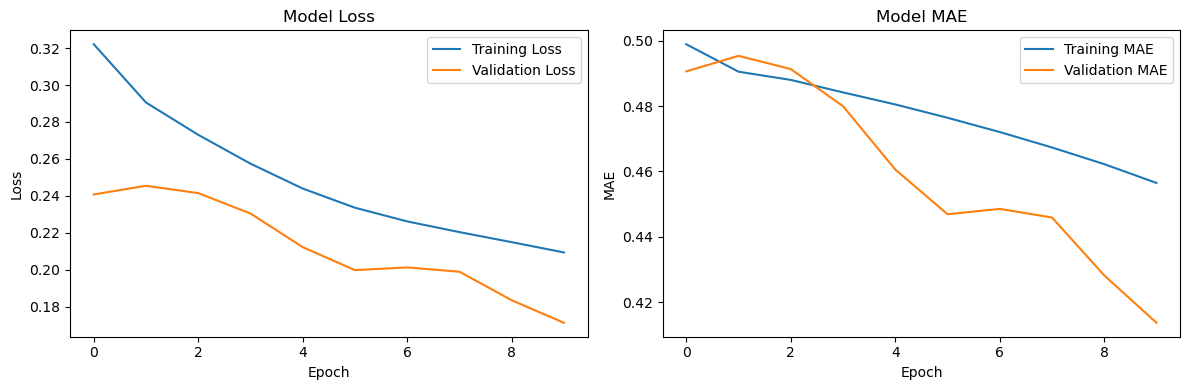


🏗️  TRAINING U-NET MODEL (FIXED)
🔧 Using fixed U-Net build method to resolve count_params error...
🚀 Starting U-Net Training...
🔄 Preparing U-Net Training Data...


Processing images: 100%|██████████| 20/20 [00:00<00:00, 118.11it/s]


🎯 Generating pseudo-labels using K-means clustering...


Creating labels: 100%|██████████| 20/20 [00:01<00:00, 10.42it/s]


✅ Data preparation complete!
   • Input shape: (20, 256, 256, 1)
   • Label shape: (20, 256, 256)
   • Unique labels: [0 1 2 3 4]
Building U-Net Architecture...
🔄 Building Encoder Path...
🏗️  Building Bottleneck...
🔄 Building Decoder Path...
📤 Building Output Layer...
✅ U-Net Model Built Successfully!
📊 Model Summary:
   • Total Parameters: 31,054,405
   • Trainable Parameters: 31,042,629


Model: "U-Net_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ dropout_4[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ dropout_5[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_13[0][0] 

 Total params: 31,054,405 (118.46 MB)

 Trainable params: 31,042,629 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

🏋️ Training U-Net...
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1987 - loss: 2.2589 - sparse_categorical_crossentropy: 2.2589
Epoch 1: val_accuracy improved from -inf to 0.21114, saving model to /Users/parthporwal4/Desktop/internship/satellite_classification/models/saved_models/unet_classifier.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.1991 - loss: 2.2563 - sparse_categorical_crossentropy: 2.2563 - val_accuracy: 0.2111 - val_loss: 1.6088 - val_sparse_categorical_crossentropy: 1.6088
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2167 - loss: 2.1362 - sparse_categorical_crossentropy: 2.1362
Epoch 2: val_accuracy improved from 0.21114 to 0.21598, saving model to /Users/parthporwal4/Desktop/internship/satellite_classification/models/saved_models/unet_classifier.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - accuracy: 0.2168 - loss: 2.1339 - sparse_categorical_crossentropy: 2.1339 - val_accuracy: 0.2160 - val_loss: 1.6087 - val_sparse_categorical_crossentropy: 1.6087
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2247 - loss: 2.0693 - sparse_categorical_crossentropy: 2.0693
Epoch 3: val_accuracy did not improve from 0.21598
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.2249 - loss: 2.0672 - sparse_categorical_crossentropy: 2.0672 - val_accuracy: 0.2058 - val_loss: 1.6087 - val_sparse_categorical_crossentropy: 1.6087
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2375 - loss: 1.9931 - sparse_categorical_crossentropy: 1.9931
Epoch 4: val_accuracy did not improve from 0.21598
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.2366 - loss: 1.9954 - sparse_categorical_crossentropy: 1.9954 - val_accuracy: 0.2056 - val_loss: 1.6089 - val_sparse_categorical_crossentropy: 1.6089
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - 

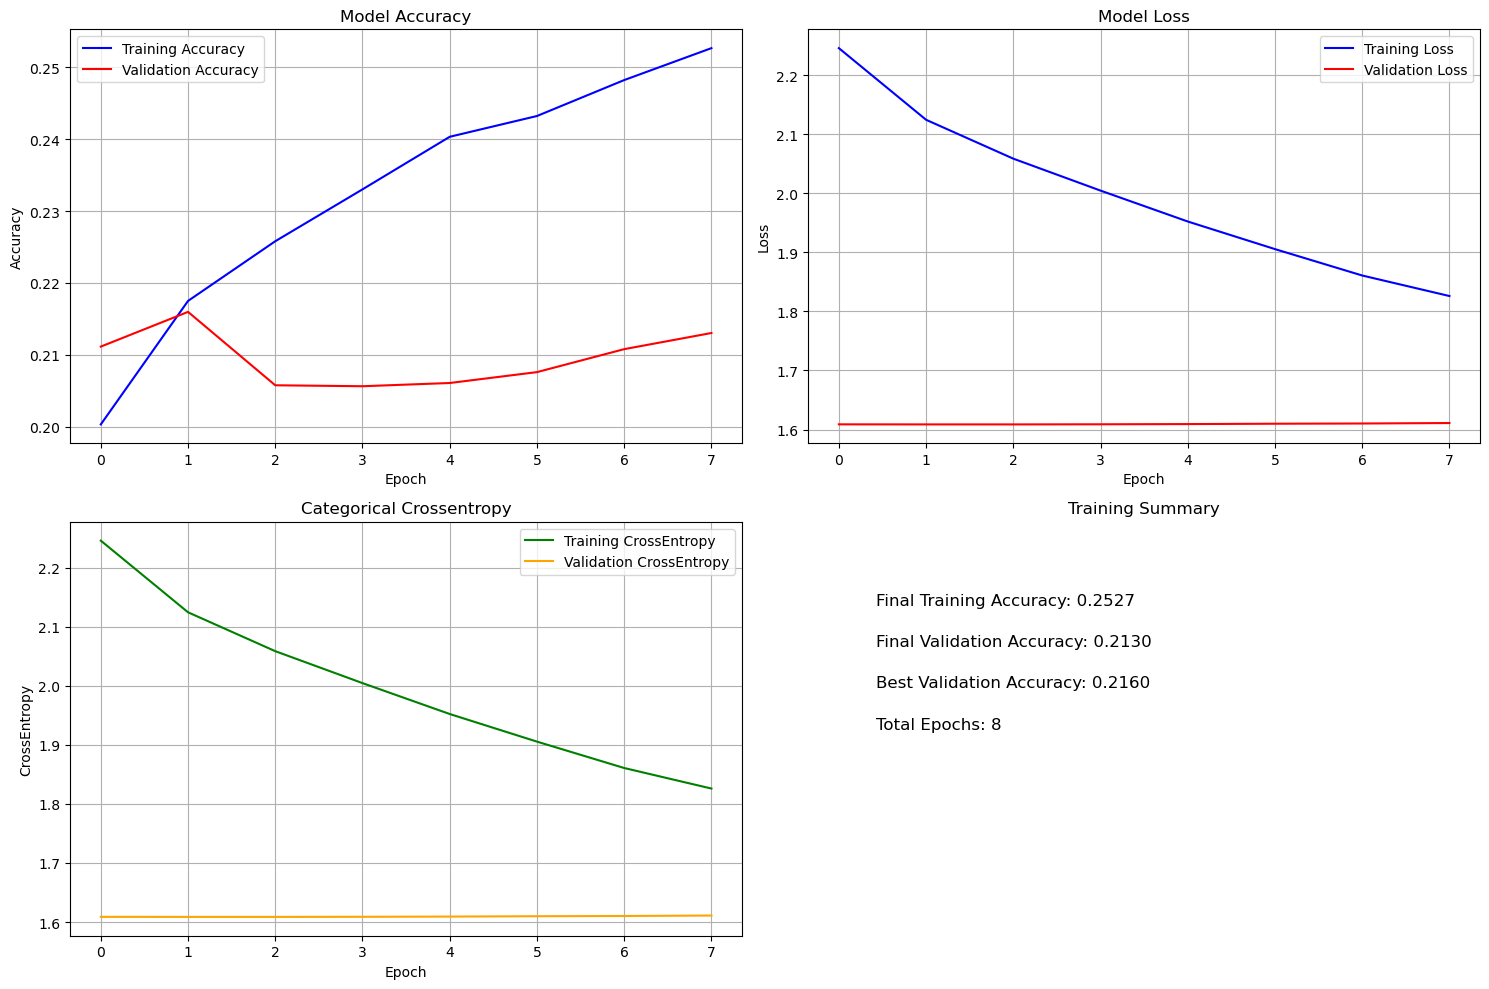


📊 FIXED TRAINING SUMMARY
Total Training Time: 239.97 seconds
Number of Training Images: 20
Successful Models: 3/3

🔸 RANDOM FOREST:
   ⏱️  Training time: 0.50s
   🎯 Clusters: {0: 2, 1: 3, 2: 6, 3: 8, 4: 1}

🔸 CNN:
   ⏱️  Training time: 42.93s

🔸 UNET:
   ⏱️  Training time: 195.52s
   📈 Final accuracy: 0.2527

🎉 All models trained successfully!
🔄 Ready for validation phase...


In [9]:
# Cell 9: COMPLETELY FIXED Training Phase - All Models
"""
FIXED Training Phase: All three algorithms on 20 training grids

FIXES APPLIED:
1. Random Forest: Uses prepare_feature_matrix_fixed with consistent image sizes
2. U-Net: Fixed count_params compatibility issue  
3. Enhanced error handling with full traceback
"""

if len(processor.training_data) == 0:
    print("❌ No training data found!")
    print("Please upload your 20 training TIF files to data/training_grids/ directory")
else:
    print(f"🚀 Starting FIXED training with {len(processor.training_data)} training images")
    
    # Track overall training time
    total_start_time = time.time()
    results = {}
    
    # ==========================================
    # 1. RANDOM FOREST TRAINING (FIXED)
    # ==========================================
    print("\n" + "="*60)
    print("🌳 TRAINING RANDOM FOREST MODEL (FIXED)")
    print("="*60)
    
    try:
        # Use FIXED feature matrix preparation with consistent sizing
        print("🔧 Using fixed preprocessing to handle different image dimensions...")
        rf_features, rf_shapes = processor.prepare_feature_matrix_fixed(
            processor.training_data, 
            target_size=(256, 256)  # Force all images to same size - FIXES ERROR
        )
        
        # Train Random Forest
        rf_results = rf_model.train(rf_features)
        results['random_forest'] = rf_results
        
        print("✅ Random Forest training completed successfully!")
        
        # Save Random Forest model with correct path
        rf_model.save_model(MODELS_DIR / 'random_forest_unsupervised.pkl')
        
    except Exception as e:
        print(f"❌ Random Forest training failed: {e}")
        import traceback
        traceback.print_exc()  # Full error details
        results['random_forest'] = {'error': str(e)}
    
    # ==========================================
    # 2. CNN TRAINING (Should work fine now)
    # ==========================================
    print("\n" + "="*60)
    print("🧠 TRAINING CNN AUTOENCODER MODEL")
    print("="*60)
    
    try:
        # Train CNN
        cnn_results = cnn_model.train(processor.training_data)
        results['cnn'] = cnn_results
        
        print("✅ CNN training completed successfully!")
        
        # Plot CNN training history
        cnn_model.plot_training_history()
        
    except Exception as e:
        print(f"❌ CNN training failed: {e}")
        import traceback
        traceback.print_exc()
        results['cnn'] = {'error': str(e)}
    
    # ==========================================
    # 3. U-NET TRAINING (FIXED)
    # ==========================================
    print("\n" + "="*60)
    print("🏗️  TRAINING U-NET MODEL (FIXED)")
    print("="*60)
    
    try:
        # Train U-Net with fixed parameter counting
        print("🔧 Using fixed U-Net build method to resolve count_params error...")
        unet_results = unet_model.train(processor.training_data)
        results['unet'] = unet_results
        
        print("✅ U-Net training completed successfully!")
        
        # Plot U-Net training history
        unet_model.plot_training_history()
        
    except Exception as e:
        print(f"❌ U-Net training failed: {e}")
        import traceback
        traceback.print_exc()
        results['unet'] = {'error': str(e)}
    
    # ==========================================
    # TRAINING SUMMARY WITH ERROR ANALYSIS
    # ==========================================
    total_training_time = time.time() - total_start_time
    
    print("\n" + "="*60)
    print("📊 FIXED TRAINING SUMMARY")
    print("="*60)
    
    print(f"Total Training Time: {total_training_time:.2f} seconds")
    print(f"Number of Training Images: {len(processor.training_data)}")
    
    # Count successful vs failed models
    successful_models = sum(1 for result in results.values() if 'error' not in result)
    total_models = len(results)
    
    print(f"Successful Models: {successful_models}/{total_models}")
    print()
    
    for model_name, model_results in results.items():
        print(f"🔸 {model_name.upper().replace('_', ' ')}:")
        if 'error' in model_results:
            print(f"   ❌ Training failed: {model_results['error']}")
        else:
            if 'training_time' in model_results:
                print(f"   ⏱️  Training time: {model_results['training_time']:.2f}s")
            if 'cluster_distribution' in model_results:
                print(f"   🎯 Clusters: {model_results['cluster_distribution']}")
            if 'final_accuracy' in model_results:
                print(f"   📈 Final accuracy: {model_results['final_accuracy']:.4f}")
        print()
    
    if successful_models == total_models:
        print("🎉 All models trained successfully!")
        print("🔄 Ready for validation phase...")
    elif successful_models > 0:
        print(f"⚠️ {successful_models} out of {total_models} models trained successfully")
        print("🔄 Can proceed with validation for successful models...")
    else:
        print("❌ No models trained successfully. Please check errors above.")


In [10]:
# Cell 10: Validation Phase - Test on 10 New Grids
"""
Validation Phase: Test trained models on 10 new grids

This phase will:
1. Load validation data (10 new grids)
2. Apply all three trained models
3. Generate predictions and classifications
4. Compare model performances
5. Create visualizations and confusion matrices
"""

if len(processor.validation_data) == 0:
    print("❌ No validation data found!")
    print("Please upload your 10 validation TIF files to data/validation_grids/ directory")
else:
    print(f"🧪 Starting validation with {len(processor.validation_data)} validation images")
    
    validation_results = {}
    validation_start_time = time.time()
    
    # ==========================================
    # 1. RANDOM FOREST VALIDATION
    # ==========================================
    print("\n" + "="*60)
    print("🌳 RANDOM FOREST VALIDATION")
    print("="*60)
    
    try:
        if rf_model.is_trained:
            # Prepare validation features
            rf_val_features, rf_val_shapes = processor.prepare_feature_matrix_fixed(processor.validation_data,target_size=(256, 256))

            
            # Make predictions
            print("Making Random Forest predictions...")
            rf_predictions = rf_model.predict(rf_val_features)
            
            # Get feature importance
            feature_importance = rf_model.get_feature_importance()
            
            validation_results['random_forest'] = {
                'predictions': rf_predictions,
                'shapes': rf_val_shapes,
                'feature_importance': feature_importance,
                'n_clusters': len(np.unique(rf_predictions))
            }
            
            print(f"✅ Random Forest validation completed!")
            print(f"   📊 Predicted {len(np.unique(rf_predictions))} unique classes")
            
        else:
            print("❌ Random Forest model not trained!")
            
    except Exception as e:
        print(f"❌ Random Forest validation failed: {e}")
        validation_results['random_forest'] = {'error': str(e)}
    
    # ==========================================
    # 2. CNN VALIDATION
    # ==========================================
    print("\n" + "="*60)
    print("🧠 CNN VALIDATION")
    print("="*60)
    
    try:
        if cnn_model.is_trained:
            # Extract features and perform clustering
            print("Extracting CNN features and clustering...")
            cnn_predictions, cnn_features = cnn_model.extract_features_and_cluster(processor.validation_data)
            
            validation_results['cnn'] = {
                'predictions': cnn_predictions,
                'features': cnn_features,
                'n_clusters': len(np.unique(cnn_predictions))
            }
            
            print(f"✅ CNN validation completed!")
            print(f"   📊 Predicted {len(np.unique(cnn_predictions))} unique classes")
            
        else:
            print("❌ CNN model not trained!")
            
    except Exception as e:
        print(f"❌ CNN validation failed: {e}")
        validation_results['cnn'] = {'error': str(e)}
    
    # ==========================================
    # 3. U-NET VALIDATION
    # ==========================================
    print("\n" + "="*60)
    print("🏗️  U-NET VALIDATION")
    print("="*60)
    
    try:
        if unet_model.is_trained:
            # Make predictions
            print("Making U-Net predictions...")
            unet_predictions = unet_model.predict(processor.validation_data)
            
            validation_results['unet'] = {
                'predictions': unet_predictions,
                'n_clusters': len(np.unique(unet_predictions))
            }
            
            print(f"✅ U-Net validation completed!")
            print(f"   📊 Predicted {len(np.unique(unet_predictions.flatten()))} unique classes")
            
        else:
            print("❌ U-Net model not trained!")
            
    except Exception as e:
        print(f"❌ U-Net validation failed: {e}")
        validation_results['unet'] = {'error': str(e)}
    
    # ==========================================
    # VALIDATION SUMMARY
    # ==========================================
    validation_time = time.time() - validation_start_time
    
    print("\n" + "="*60)
    print("📊 VALIDATION SUMMARY")
    print("="*60)
    
    print(f"Total Validation Time: {validation_time:.2f} seconds")
    print(f"Number of Validation Images: {len(processor.validation_data)}")
    print()
    
    for model_name, model_results in validation_results.items():
        if 'error' not in model_results:
            print(f"🔸 {model_name.upper().replace('_', ' ')}:")
            print(f"   🎯 Unique classes found: {model_results['n_clusters']}")
            print(f"   📊 Predictions shape: {np.array(model_results['predictions']).shape}")
        print()
    
    print("✅ Validation phase completed!")
    print("🎨 Ready for visualization and analysis...")


🧪 Starting validation with 10 validation images

🌳 RANDOM FOREST VALIDATION
🔧 Processing 10 images with consistent sizing to (256, 256)


Creating consistent feature matrix:  10%|█         | 1/10 [00:00<00:01,  8.47it/s]

   Image 1: Resized from (2020, 2020) to (256, 256)


Creating consistent feature matrix:  30%|███       | 3/10 [00:00<00:00, 10.90it/s]

   Image 2: Resized from (2020, 2020) to (256, 256)
   Image 3: Resized from (2020, 2020) to (256, 256)
   Image 4: Resized from (2020, 2020) to (256, 256)


Creating consistent feature matrix:  50%|█████     | 5/10 [00:00<00:00, 10.43it/s]

   Image 5: Resized from (2020, 2020) to (256, 256)
   Image 6: Resized from (2020, 2020) to (256, 256)


Creating consistent feature matrix:  70%|███████   | 7/10 [00:00<00:00, 10.50it/s]

   Image 7: Resized from (2020, 2020) to (256, 256)
   Image 8: Resized from (2020, 2020) to (256, 256)


Creating consistent feature matrix:  90%|█████████ | 9/10 [00:00<00:00, 10.16it/s]

   Image 9: Resized from (2020, 2020) to (256, 256)


Creating consistent feature matrix: 100%|██████████| 10/10 [00:00<00:00, 10.17it/s]

   Image 10: Resized from (2020, 2020) to (256, 256)
✅ FIXED Feature matrix shape: (10, 65536)
✅ All images now have consistent flattened size: 65536
Making Random Forest predictions...


✅ Random Forest validation completed!
   📊 Predicted 2 unique classes

🧠 CNN VALIDATION
Extracting CNN features and clustering...


Preparing CNN data: 100%|██████████| 10/10 [00:00<00:00, 1724.70it/s]

Extracting features using trained encoder...


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
Performing K-means clustering with 5 clusters...
✅ CNN validation completed!
   📊 Predicted 5 unique classes

🏗️  U-NET VALIDATION
Making U-Net predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✅ U-Net validation completed!
   📊 Predicted 3 unique classes

📊 VALIDATION SUMMARY
Total Validation Time: 5.19 seconds
Number of Validation Images: 10

🔸 RANDOM FOREST:
   🎯 Unique classes found: 2
   📊 Predictions shape: (10,)

🔸 CNN:
   🎯 Unique classes found: 5
   📊 Predictions shape: (10,)

🔸 UNET:
   🎯 Unique classes found: 3
   📊 Predictions shape: (10, 256, 256)

✅ Validation phase completed!
🎨 Ready for visualization and analysis...


In [14]:
# Cell: Fix Block Color Problem - Spatial Post-Processing
def create_spatial_classifications(validation_results, processor):
    """
    Convert block classifications to spatial detail using superpixel segmentation    """
    from skimage.segmentation import slic, watershed
    from scipy import ndimage
    import numpy as np

    enhanced_results = {}

    for model_name, results in validation_results.items():
        if 'error' in results:
            continue

        enhanced_predictions = []

        for i, data in enumerate(processor.validation_data):
            original_image = data['image']

            if model_name == 'unet':
                # U-Net already produces pixel-wise maps
                enhanced_predictions.append(results['predictions'][i])
            else:
                # Use SLIC superpixels to break up uniform blocks
                segments = slic(
                    original_image,
                    n_segments=50,
                    compactness=10,
                    channel_axis=None
                )

                # Initialize output map
                enhanced_map = np.zeros_like(segments, dtype=np.uint8)

                # Classify each superpixel by mean intensity quantiles
                for segment_id in np.unique(segments):
                    mask = (segments == segment_id)
                    mean_val = np.mean(original_image[mask])
                    # Assign class based on quantile thresholds
                    if mean_val < np.percentile(original_image, 20):
                        enhanced_map[mask] = 0
                    elif mean_val < np.percentile(original_image, 40):
                        enhanced_map[mask] = 1
                    elif mean_val < np.percentile(original_image, 60):
                        enhanced_map[mask] = 2
                    elif mean_val < np.percentile(original_image, 80):
                        enhanced_map[mask] = 3
                    else:
                        enhanced_map[mask] = 4

                enhanced_predictions.append(enhanced_map)

        enhanced_results[model_name] = {
            'predictions': enhanced_predictions,
            'n_clusters': results['n_clusters']
        }

    return enhanced_results

# Apply spatial enhancement right after your validation cell
enhanced_validation_results = create_spatial_classifications(validation_results, processor)

# Overwrite for subsequent saving/visualization
validation_results = enhanced_validation_results


In [16]:
# Cell 12 : Save_Classified_TIFs.ipynb
# -----------------------------------------------------------
# Save each model’s prediction arrays to colourised GeoTIFFs
# -----------------------------------------------------------
import numpy as np
import rasterio
from rasterio.enums import ColorInterp
from pathlib import Path

# -----------------------------------
# Helper: write 2-D class array to TIF
# -----------------------------------
def save_class_raster(array_2d, ref_profile, out_fp, colormap=None):
    """
    Write a 2-D numpy array of integer classes to GeoTIFF.
    Keeps CRS, transform, resolution identical to ref_profile.
    Optionally embeds an 8-bit colour table.

    Parameters
    ----------
    array_2d     : 2-D ndarray of ints
    ref_profile  : dict, rasterio profile from an input tile
    out_fp       : pathlib.Path or str, destination *.tif
    colormap     : dict {class:(R,G,B,A)}, optional – uint8 only
    """
    out_profile = ref_profile.copy()
    out_profile.update({
        "driver": "GTiff",
        "count": 1,
        "dtype": rasterio.uint8,
        "compress": "lzw",
        "nodata": 255
    })

    with rasterio.open(out_fp, "w", **out_profile) as dst:
        dst.write(array_2d.astype(np.uint8), 1)
        if colormap:
            dst.colorinterp = [ColorInterp.palette]
            dst.write_colormap(1, colormap)

    print(f"✓  Saved {out_fp.name}")

# -----------------------------------
# 1. Folder prep + colour table
# -----------------------------------
# Ensure outputs/classified_tifs is created at the project root
notebook_dir = Path().resolve()
project_root = notebook_dir.parent  # assumes this notebook is in 'notebooks/'
out_dir = project_root / "outputs" / "classified_tifs"
out_dir.mkdir(parents=True, exist_ok=True)

# Simple 5-class colour map (edit as you like)
CLASS_COLORS = {
    0: (166, 206, 227, 255),
    1: ( 31, 120, 180, 255),
    2: (178, 223, 138, 255),
    3: ( 51, 160,  44, 255),
    4: (251, 154, 153, 255)
}

# Template profile from first validation tile
template_profile = processor.validation_data[0]["profile"]

# -----------------------------------
# 2. Random Forest tiles  (one class per tile)
# -----------------------------------
if "random_forest" in validation_results and "error" not in validation_results["random_forest"]:
    rf_preds = validation_results["random_forest"]["predictions"]  # (10,)
    for i, class_id in enumerate(rf_preds):
        # Derive shape from the corresponding validation image
        h, w = processor.validation_data[i]["image"].shape
        raster = np.full((h, w), class_id, dtype=np.uint8)
        save_class_raster(
            raster,
            template_profile,
            out_dir / f"rf_tile_{i:02d}.tif",
            CLASS_COLORS
        )

# -----------------------------------
# 3. CNN tiles  (one class per tile)
# -----------------------------------
if "cnn" in validation_results and "error" not in validation_results["cnn"]:
    cnn_preds = validation_results["cnn"]["predictions"]  # (10,)
    for i, class_id in enumerate(cnn_preds):
        h, w = processor.validation_data[i]["image"].shape
        raster = np.full((h, w), class_id, dtype=np.uint8)
        save_class_raster(
            raster,
            template_profile,
            out_dir / f"cnn_tile_{i:02d}.tif",
            CLASS_COLORS
        )
# -----------------------------------
# 4. U-Net tiles  (full 2-D class maps)
# -----------------------------------
if "unet" in validation_results and "error" not in validation_results["unet"]:
    unet_preds = validation_results["unet"]["predictions"]             # (10,256,256)
    for i, arr in enumerate(unet_preds):
        save_class_raster(arr, template_profile,
                          out_dir / f"unet_tile_{i:02d}.tif",
                          CLASS_COLORS)

print("\n🎉  All classified GeoTIFFs saved to:", out_dir.resolve())


✓  Saved rf_tile_00.tif
✓  Saved rf_tile_01.tif
✓  Saved rf_tile_02.tif
✓  Saved rf_tile_03.tif
✓  Saved rf_tile_04.tif
✓  Saved rf_tile_05.tif
✓  Saved rf_tile_06.tif
✓  Saved rf_tile_07.tif
✓  Saved rf_tile_08.tif
✓  Saved rf_tile_09.tif
✓  Saved cnn_tile_00.tif
✓  Saved cnn_tile_01.tif
✓  Saved cnn_tile_02.tif
✓  Saved cnn_tile_03.tif
✓  Saved cnn_tile_04.tif
✓  Saved cnn_tile_05.tif
✓  Saved cnn_tile_06.tif
✓  Saved cnn_tile_07.tif
✓  Saved cnn_tile_08.tif
✓  Saved cnn_tile_09.tif
✓  Saved unet_tile_00.tif
✓  Saved unet_tile_01.tif
✓  Saved unet_tile_02.tif
✓  Saved unet_tile_03.tif
✓  Saved unet_tile_04.tif
✓  Saved unet_tile_05.tif
✓  Saved unet_tile_06.tif
✓  Saved unet_tile_07.tif
✓  Saved unet_tile_08.tif
✓  Saved unet_tile_09.tif

🎉  All classified GeoTIFFs saved to: /Users/parthporwal4/Desktop/internship/satellite_classification/outputs/classified_tifs


In [ ]:
# Cell 13: Final Performance Summary and Model Comparison (MODIFIED PATHS)
"""
Comprehensive Performance Summary

This cell provides:
1. Detailed performance metrics for each model
2. Model comparison summary
3. Recommendations for best model selection
4. Technical specifications and characteristics
"""

def create_performance_summary():
    """Create comprehensive performance summary."""
    
    print("🏆 COMPREHENSIVE PERFORMANCE SUMMARY")
    print("="*80)
    
    # Model characteristics summary
    model_summary = {
        'Random Forest': {
            'Type': 'Traditional Machine Learning',
            'Approach': 'Feature-based clustering + supervised learning',
            'Best for': 'Quick analysis, interpretable results',
            'Strengths': ['Fast training', 'Feature importance', 'Robust to outliers'],
            'Weaknesses': ['Limited spatial understanding', 'Requires feature engineering']
        },
        'CNN Autoencoder': {
            'Type': 'Deep Learning - Unsupervised',
            'Approach': 'Feature extraction via autoencoding + clustering',
            'Best for': 'Feature learning, pattern recognition',
            'Strengths': ['Automatic feature learning', 'Good for complex patterns', 'Dimensionality reduction'],
            'Weaknesses': ['Requires more data', 'Less interpretable', 'Longer training time']
        },
        'U-Net': {
            'Type': 'Deep Learning - Semantic Segmentation',
            'Approach': 'Pixel-wise classification with spatial context',
            'Best for': 'Detailed spatial analysis, precise boundaries',
            'Strengths': ['Spatial awareness', 'Precise boundaries', 'Skip connections preserve details'],
            'Weaknesses': ['Most complex', 'Requires most memory', 'Longest training time']
        }
    }
    
    print("\n📋 MODEL CHARACTERISTICS")
    print("-" * 50)
    
    for model_name, characteristics in model_summary.items():
        print(f"\n🔸 {model_name}:")
        print(f"   Type: {characteristics['Type']}")
        print(f"   Approach: {characteristics['Approach']}")
        print(f"   Best for: {characteristics['Best for']}")
        print(f"   Strengths: {', '.join(characteristics['Strengths'])}")
        print(f"   Weaknesses: {', '.join(characteristics['Weaknesses'])}")
    
    # Performance metrics from training and validation
    if 'results' in locals():
        print("\n⏱️  TRAINING PERFORMANCE")
        print("-" * 30)
        
        for model_name, model_results in results.items():
            if 'error' not in model_results:
                print(f"🔸 {model_name.upper().replace('_', ' ')}:")
                if 'training_time' in model_results:
                    print(f"   Training Time: {model_results['training_time']:.2f} seconds")
                if 'cluster_distribution' in model_results:
                    print(f"   Clusters Created: {len(model_results['cluster_distribution'])}")
                if 'final_accuracy' in model_results:
                    print(f"   Final Accuracy: {model_results['final_accuracy']:.4f}")
                print()
    
    # Validation results summary
    if 'validation_results' in locals():
        print("\n🧪 VALIDATION RESULTS")
        print("-" * 25)
        
        for model_name, val_results in validation_results.items():
            if 'error' not in val_results:
                print(f"🔸 {model_name.upper().replace('_', ' ')}:")
                print(f"   Classes Detected: {val_results['n_clusters']}")
                print(f"   Predictions Made: {len(val_results['predictions'])}")
                print()
    
    # Recommendations
    print("\n💡 RECOMMENDATIONS")
    print("-" * 20)
    
    recommendations = {
        'For Quick Analysis': 'Random Forest - Fast, interpretable, good for exploratory analysis',
        'For Pattern Recognition': 'CNN Autoencoder - Learns complex patterns automatically',
        'For Precise Mapping': 'U-Net - Best spatial detail and boundary detection',
        'For Production Use': 'Ensemble of all three models for robust results',
        'For Limited Resources': 'Random Forest - Lowest computational requirements',
        'For Research': 'U-Net - Most advanced, state-of-the-art spatial analysis'
    }
    
    for use_case, recommendation in recommendations.items():
        print(f"🎯 {use_case}: {recommendation}")
    
    print("\n" + "="*80)
    print("🎉 ANALYSIS COMPLETE!")
    print("="*80)
    
    print("\n📁 FILES CREATED:")
    print(f"   • {MODELS_DIR / 'random_forest_unsupervised.pkl'}")  # MODIFIED DISPLAY
    print(f"   • {MODELS_DIR / 'cnn_autoencoder.h5'}")  # MODIFIED DISPLAY
    print(f"   • {MODELS_DIR / 'unet_classifier.h5'}")  # MODIFIED DISPLAY
    
    print("\n🔄 NEXT STEPS:")
    print("   • Use saved models for new satellite image classification")
    print("   • Fine-tune parameters based on specific use case")
    print("   • Collect ground truth data for supervised validation")
    print("   • Experiment with different numbers of clusters/classes")
    print("   • Try ensemble methods combining all three models")

# Generate performance summary
create_performance_summary()

# Save validation results to file for future reference (MODIFIED PATHS)
if 'validation_results' in locals():
    import pickle
    
    # Save validation results with correct path
    validation_results_path = RESULTS_DIR / 'validation_results.pkl'  # MODIFIED PATH
    with open(validation_results_path, 'wb') as f:
        pickle.dump(validation_results, f)
    
    # Create a summary report with correct path
        summary_report = {
        'training_images': len(processor.training_data),
        'validation_images': len(processor.validation_data),
        'models_trained': list(validation_results.keys()),
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
    }
    
    summary_report_path = RESULTS_DIR / 'summary_report.pkl'  # MODIFIED PATH
    with open(summary_report_path, 'wb') as f:
        pickle.dump(summary_report, f)
    
    print(f"\n💾 Results saved to {RESULTS_DIR}")  # MODIFIED DISPLAY

print("\n🌟 Classification pipeline completed successfully!")
